<a href="https://colab.research.google.com/github/WiryawanCEO/IndonesianBanknotes-ImageClassificationModel/blob/main/final_model_cnn_rena2019_dataset6000_sidangready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import library dan depedencies yang akan digunakan

In [ ]:
import tensorflow as tf
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math

from google.colab import drive
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Buat koneksi dengan Google Drive

In [ ]:
drive.mount('/content/drive')
base = Path('/content/drive/My Drive/')
sys.path.append(str(base))

zip_path = base/'Dataset73.zip'
!cp '{zip_path}' .

!unzip -q Dataset73.zip
!rm Dataset73.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Definisikan direktori dataset di Google Drive, serta setup datagenerator dataset training & validasi

In [ ]:
train_dir = 'Dataset73/train'
validation_dir = 'Dataset73/valid'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

Masukan dataset kedalam generator berdasarkan batch, kemudian resize ke ukuran 224x224 dengan mode kelas berdasarkan kategorikal

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=100,
        shuffle=False,
        class_mode='categorical')

Found 4200 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.


Buat file labels.txt untuk referensi label kelas di implementasi nantinya sekaligus digunakan pada tahap evaluasi dengan confusion matrix dan classification report

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'100rb': 0, '10rb': 1, '20rb': 2, '2rb': 3, '50rb': 4, '5rb': 5}


Konstruksikan model sesuai dengan referensi skripsi rena(2019) dengan perubahan pada ukuran input dan lapisan fully-connected akhirnya

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                      activation='relu',input_shape=(224,224,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              9

Konfigurasi parameter pelatihan dan mulai proses training-nya

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=42,  # 4200 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=18,  # 1800 images = batch_size * steps
      verbose=1)

Epoch 1/20
42/42 [==============================] - 75s 2s/step - loss: 1.7626 - categorical_accuracy: 0.2464 - val_loss: 1.5120 - val_categorical_accuracy: 0.4550
Epoch 2/20
42/42 [==============================] - 76s 2s/step - loss: 1.2776 - categorical_accuracy: 0.5140 - val_loss: 1.0242 - val_categorical_accuracy: 0.6628
Epoch 3/20
42/42 [==============================] - 77s 2s/step - loss: 0.8952 - categorical_accuracy: 0.6798 - val_loss: 0.7095 - val_categorical_accuracy: 0.7778
Epoch 4/20
42/42 [==============================] - 75s 2s/step - loss: 0.6204 - categorical_accuracy: 0.7914 - val_loss: 0.5787 - val_categorical_accuracy: 0.8050
Epoch 5/20
42/42 [==============================] - 76s 2s/step - loss: 0.4932 - categorical_accuracy: 0.8336 - val_loss: 0.5123 - val_categorical_accuracy: 0.8256
Epoch 6/20
42/42 [==============================] - 75s 2s/step - loss: 0.4361 - categorical_accuracy: 0.8564 - val_loss: 0.4688 - val_categorical_accuracy: 0.8267
Epoch 7/20
42/42

Evaluasi hasil pelatihan dengan grafik visualisasi proses training

Text(0.5, 1.0, 'Training and validation loss')

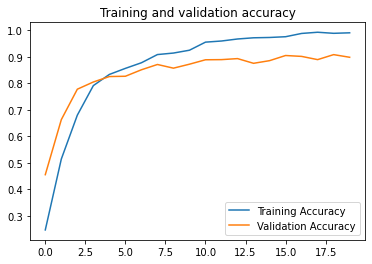

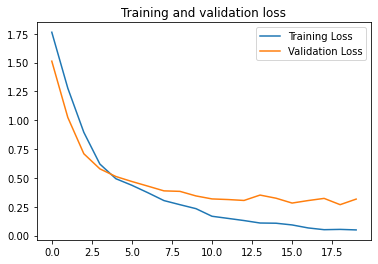

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

Evaluasi akurasi akhir model pada kumpulan dataset validasi

In [ ]:
validation_generator.reset()
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
model.evaluate(validation_generator, steps=STEP_SIZE_VALID)

18/18 [==============================] - 21s 1s/step - loss: 0.3165 - categorical_accuracy: 0.8983


[0.31647342443466187, 0.8983333110809326]

Definisikan plotting confusion matrix terlebih dahulu

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title='Normalized confusion matrix'
        else:
            title='Confusion matrix'

        # Calculate chart area size
        leftmargin = 0.5 # inches
        rightmargin = 0.5 # inches
        categorysize = 0.5 # inches
        figwidth = leftmargin + rightmargin + (len(classes) * categorysize)           

        f = plt.figure(figsize=(figwidth, figwidth))

        # Create an axes instance and ajust the subplot size
        ax = f.add_subplot(111)
        ax.set_aspect(1)
        f.subplots_adjust(left=leftmargin/figwidth, right=1-rightmargin/figwidth, top=0.94, bottom=0.1)

        res = ax.imshow(cm, interpolation='nearest', cmap=cmap)

        plt.title(title)
        plt.colorbar(res)
        ax.set_xticks(range(len(classes)))
        ax.set_yticks(range(len(classes)))
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_yticklabels(classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

        # plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Evaluasi klasifikasi dengan menggunakan confusion matrix

<Figure size 432x288 with 0 Axes>

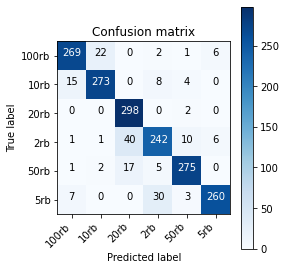

<Figure size 432x288 with 0 Axes>

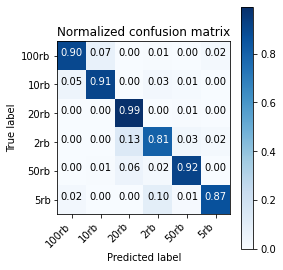

In [ ]:
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=STEP_SIZE_VALID)
y_pred = np.argmax(Y_pred, axis=1)
target_names = !cat labels.txt

cm = confusion_matrix(validation_generator.classes, y_pred)

# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True, title='Normalized confusion matrix')

plt.show()

Evaluasi klasifikasi dengan laporan klasifikasi (classification report)

In [ ]:
print('Classification Report')
target_names = !cat labels.txt
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       100rb       0.92      0.90      0.91       300
        10rb       0.92      0.91      0.91       300
        20rb       0.84      0.99      0.91       300
         2rb       0.84      0.81      0.82       300
        50rb       0.93      0.92      0.92       300
         5rb       0.96      0.87      0.91       300

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



Simpan model dan konversikan kedalam format TensorFlow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open ("cnn_rena2019_dataset6000.tflite" , "wb") .write(tflite_model)

384364796

In [ ]:
model.save("cnn_rena2019_dataset6000.h5")